In [9]:
import numpy as np
import xgboost as xgb
import pandas as pd
pd.options.display.max_columns = None
from utils import create_time_series_splits
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [4]:
df = pd.read_parquet('../data/datasets_2023-2025_beta.parquet')
df.timestamp = pd.to_datetime(df.timestamp, unit = 's')
usd_coins = ["DAIUSD_720.parquet", "USDCUSD_720.parquet", "USDTUSD_720.parquet", "USTUSD_720.parquet"]
currencies = ["AUDUSD_720.parquet", "EURUSD_720.parquet", "GBPUSD_720.parquet"]
commodities = ['PAXGUSD_720.parquet']

df = df[~df.filename.isin(usd_coins + currencies + commodities)]
df['log_return'] = df.groupby('filename')['close'].transform(lambda x: np.log(x / x.shift(1)))
df['next_return'] = df.groupby('filename')['log_return'].shift(-1)
df = df[df['log_return'].notna()]
df = df[df['next_return'].notna()]

### One model for all

In [52]:
train_dfs, test_dfs = create_time_series_splits(df, date_column='timestamp')

all_preds = []

for train_df, test_df in zip(train_dfs, test_dfs):
    X_train = train_df.drop(columns=['next_return', 'timestamp', 'filename'])
    y_train = train_df['next_return']
    X_test = test_df.drop(columns=['next_return', 'timestamp', 'filename'])
    y_test = test_df['next_return']
    
    model = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.001,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    test_df['pred'] = preds
    all_preds.append(test_df[['timestamp', 'filename', 'pred', 'next_return']])
all_preds_df = pd.concat(all_preds, ignore_index=True)
# all_preds_df.to_parquet('RF_predictions_one_model.parquet', index=False)

In [53]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0241, MSE: 0.0014, R2: -0.0054, RMSE: 0.0378


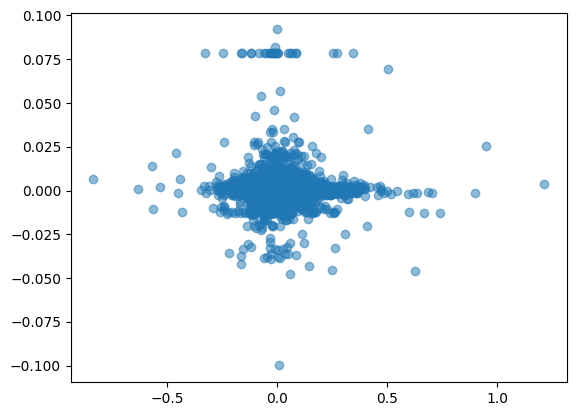

In [54]:
plt.scatter(all_preds_df['next_return'], all_preds_df['pred'], alpha=0.5)

In [55]:
all_preds_df.groupby('filename').apply(
    lambda x: pd.Series({
        'mse': mean_squared_error(x['next_return'], x['pred']),
        'mae': mean_absolute_error(x['next_return'], x['pred']),
        'r2': r2_score(x['next_return'], x['pred'])
    })
).reset_index().sort_values('r2')

,filename,mse,mae,r2
50,KEYUSD_720.parquet,0.001940,0.026496,-0.049165
90,XLMUSD_720.parquet,0.001143,0.018027,-0.032450
17,BSXUSD_720.parquet,0.003320,0.034927,-0.030095
47,JASMYUSD_720.parquet,0.001920,0.028723,-0.022801
92,XRPUSD_720.parquet,0.000949,0.016448,-0.020433
...,...,...,...,...
84,STXUSD_720.parquet,0.001583,0.027722,0.003026
70,POLISUSD_720.parquet,0.002292,0.034722,0.003267
2,ACHUSD_720.parquet,0.001358,0.025569,0.004653
91,XMRUSD_720.parquet,0.000493,0.014075,0.008604


In [58]:
all_preds_df.sort_values('timestamp', inplace=True)

In [62]:
all_preds_df['error'] = all_preds_df['pred'] - all_preds_df['next_return']
all_preds_df = all_preds_df.set_index('timestamp')
all_preds_df['rolling_std'] = all_preds_df['error'].rolling(window='60D').std()
all_preds_df['rolling_rmse'] = all_preds_df['error'].rolling(window='60D') \
    .apply(lambda x: np.sqrt(np.mean(x**2)), raw=True)



In [64]:
all_preds_df.reset_index(inplace=True)

In [104]:
tmp = all_preds_df.loc[all_preds_df.timestamp > '2023-09-01']

In [107]:
tmp['z_score'] = (tmp['pred']) / tmp['rolling_std']

In [137]:
tmp['traded'] = np.where(
    (tmp['z_score'] > 0.5),
    1,
    0
)

In [138]:
tmp['pnl'] = tmp['traded'] * (tmp['next_return']) * (10000) * np.sign(tmp['z_score'])

<Axes: >

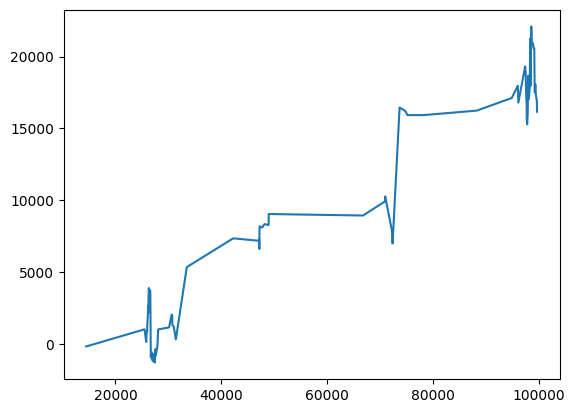

In [141]:
tmp.loc[tmp.traded != 0].pnl.cumsum().plot()

In [140]:
tmp.loc[tmp.traded != 0].pnl.describe()

count      82.000000
mean      197.063560
std      1702.746949
min     -4596.882883
25%      -480.757616
50%       -71.153994
75%       650.326966
max      9473.813189
Name: pnl, dtype: float64